In [1]:
import KeithleyGUI.keithley as keithley
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pymeasure.instruments.resources import list_resources
import time
%matplotlib inline
try : 
    a = list(list_resources())
except Exception as E:
    print(E)
    pass
K = keithley.Keithley6517B()

0 : ASRL3::INSTR : Not known
1 : GPIB0::27::INSTR : KEITHLEY INSTRUMENTS INC.,MODEL 6517B,1355622,A12/700x 


In [20]:
K = keithley.Keithley6517B()


In [2]:
def measure_IV(device, vmin = 0.5 + 0.5e-3, vmax = 0.5 + 1.0e-3, npoints = 10):
    for v_val in np.linspace(vmin, vmax, npoints):
        device.set_voltage(v_val)
        yield (v_val, device.read_current(autorange=False))
    device.set_voltage(0)
    # device.close()

In [3]:
def find_range(current):
    ranges = 2 * 10.0**np.arange(-12.0, -4.0, 1.0)
    idx = np.where(ranges > current)[0]
    if len(idx) > 0:
        return ranges[min(idx)]
    return None

In [4]:
# K.set_voltage_range(2)
# K.device.write(":SENS:FUNC 'CURR';")
# K.device.write(":SENS:CURR:RANG:AUTO OFF;:SENS:CURR:RANG 2e-10")
K.device.write(":SENS:CURR:NPLC 10;")
K.device.write(":SENS:CURR:RANG?;")
K.device.read()
K.device.write(":SENS:CURR:RANG:AUTO ON;")
K.device.write(":SENS:CURR:RANG:AUTO ON;:SENS:CURR:RANG 2e-9")
K.device.write(":READ?;")
K.device.read()
K.device.read()

<Mock name='mock.read()' id='4793481120'>

In [4]:
def auto_range_1(device, v):
    
    def find_range(current):
        ranges = 2 * 10.0**np.arange(-12.0, -4.0, 1.0)
        idx = np.where(ranges > current)[0]
        if len(idx) > 0:
            return ranges[min(idx)]
        return None
    
    device.set_voltage(v)
    c = device.read_current(autorange = False)
    rng = device.get_current_range()

    if abs(c*1.5) > rng:
        c = K.read_current(autorange=True)
        rng = K.get_current_range()
    else:
        if abs(c) < rng/100:
            K.set_current_range(find_range(abs(c*10)))
            c = K.read_current(autorange=False)
            rng = K.get_current_range()

    return (c, rng)

In [5]:
def auto_range_2(device, v, p1=None, p2=None):
    device.set_voltage(v)
    c = device.read_current() 
    rng = device.get_current_range()
    if p1 is None and p2 is None:
        c = device.read_current(autorange=True)
        device.set_current_range(device.get_current_range())
    elif (not p1 is None) and p2 is None:
        if rng > abs(c)*1.5 and 100 * abs(c) > rng:
            return c 
        elif rng < abs(c)*1.5:
            device.set_current_range(10 * rng)
        else:
            device.set_current_range(rng / 10)
        c = device.read_current()
        return c 
    else:
        direction = np.sign(p2 - p1)
        if not (rng > abs(c)*1.5 and 100 * abs(c) > rng):
            if direction == 1:
                device.set_current_range(device.get_current_range() * 10)
            if direction == -1:
                device.set_current_range(device.get_current_range() / 10)
    c = device.read_current()
    return c if c < 10 else device.read_current(autorange=True)

In [6]:
def auto_range_3(device, v, p1=None):
    device.set_voltage(v)
    if p1 is None:
        c = device.read_current(autorange=True)
        device.set_current_range(find_range(abs(c) * 10))
    else:
        device.set_current_range(find_range(abs(p1) * 10))
        c = device.read_current()
    return c if c < 10 else device.read_current(autorange=True)

In [7]:
r = []
V = np.concat([np.linspace(-10, -1, 50), np.linspace(-0.9, -0.09, 25), np.linspace(-0.09, 0.09, 25), np.linspace(0.09, 0.9, 25), np.linspace(1, 10, 50)])
V = np.concat([V, V[::-1]])
for v in V:
    r.append(auto_range_1(K, v))
K.set_voltage(0)

I = np.array([i[0] for i in r])
rng = np.array([i[1] for i in r])

Current range set to 2e-09 A
Current range set to 2e-09 A
Current range set to 2e-09 A
Current range set to 2e-09 A
Current range set to 2e-09 A
Current range set to 2e-09 A


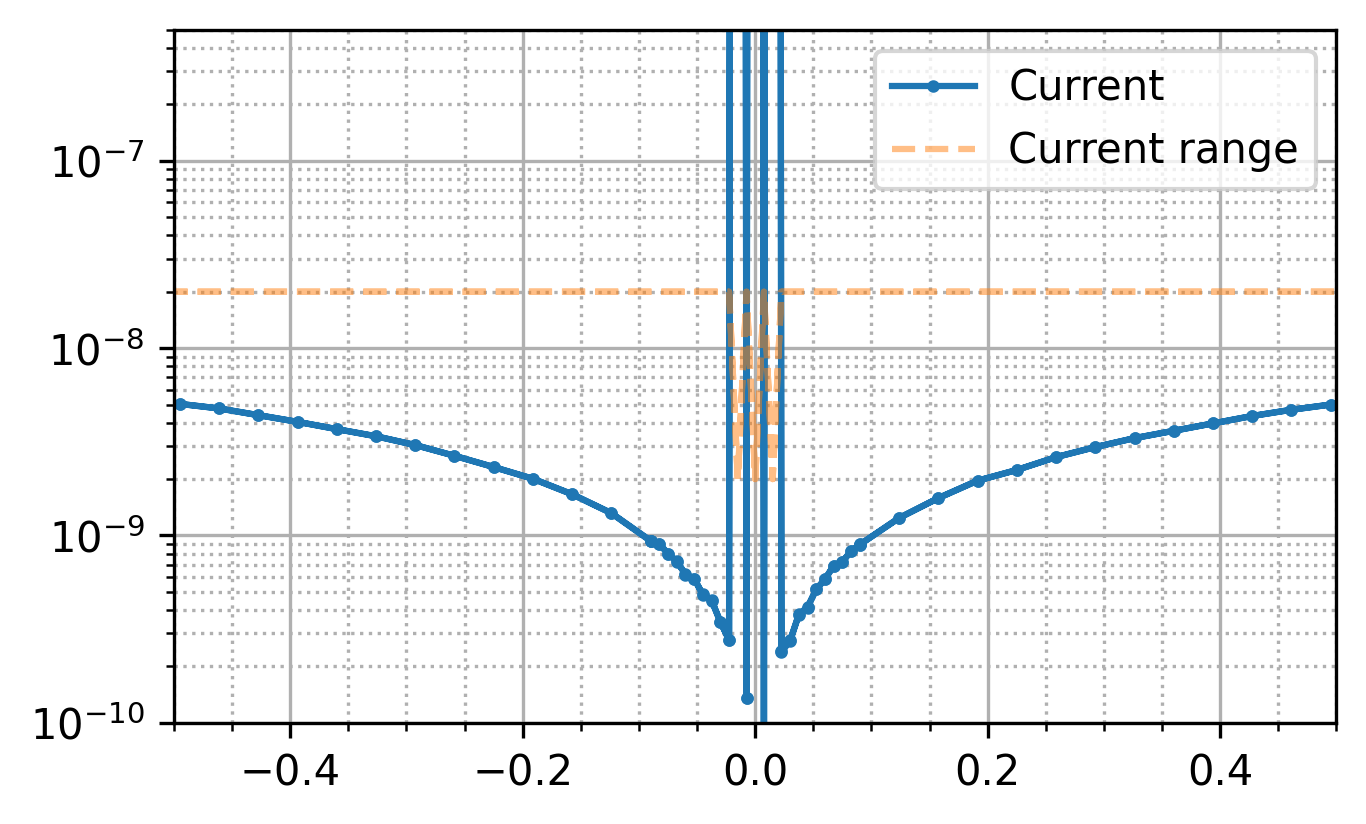

In [8]:
plt.figure(figsize=(5, 3), dpi=300)

plt.plot(V, abs(I), 'o-', label='Current', markersize=2)
plt.plot(V, rng, label='Current range', linestyle='--', alpha=0.5)
# plt.vlines([-0.10204081632653073, 0.1428571428571428 ], ymin = 0, ymax=1e38, color='black', linestyles=':')
plt.ylim(1e-10, 5e-7)
plt.xlim(-0.5, 0.5)
plt.minorticks_on()
plt.grid(visible=True, which='major') 
plt.grid(visible=True, which='minor', linestyle=':') 
plt.yscale('log')
plt.legend();

In [11]:
r1 = []
for v in V:
    if len(r1) >= 2:
        c = auto_range_2(K, v, p1=r1[-2][0], p2=r1[-1][0])
    elif len(r1) ==1:
        c = auto_range_2(K, v, p1=r1[-1][0])
    else:
        c = auto_range_2(K, v)
    r1.append([c, K.get_current_range()])
K.set_voltage(0)

I1 = np.array([i[0] for i in r1])
rng1 = np.array([i[1] for i in r1])

KeyboardInterrupt: 

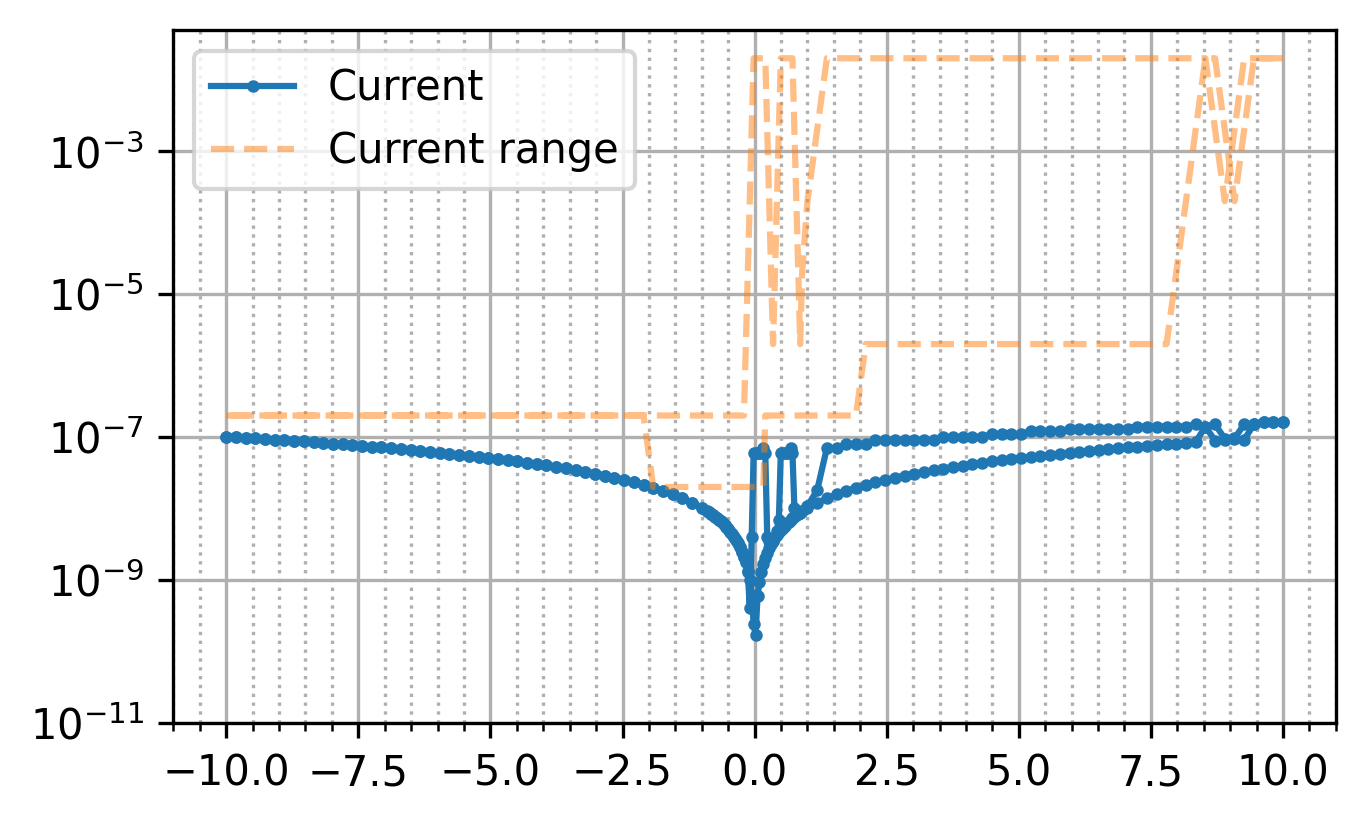

In [131]:
plt.figure(figsize=(5, 3), dpi=300)

plt.plot(V, abs(I1), 'o-', label='Current', markersize=2)
plt.plot(V, rng1, label='Current range', linestyle='--', alpha=0.5)
# plt.vlines([-0.10204081632653073, 0.1428571428571428 ], ymin = 0, ymax=1e38, color='black', linestyles=':')
plt.ylim(1e-11, 5e-2)
# plt.xlim(0, 0.2)
plt.minorticks_on()
plt.grid(visible=True, which='major') 
plt.grid(visible=True, which='minor', linestyle=':') 
plt.yscale('log')
plt.legend();

In [9]:
r2 = []
for v in V:
    if len(r2) >= 2:
        c = auto_range_3(K, v, p1=r2[-2][0])
    elif len(r2) ==1:
        c = auto_range_3(K, v, p1=r2[-1][0])
    else:
        c = auto_range_3(K, v)
    r2.append([c, K.get_current_range()])
K.set_voltage(0)

I2 = np.array([i[0] for i in r2])
rng2 = np.array([i[1] for i in r2])

Current range set to 2e-07 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-07 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-09 A
Current range set to 2e-08 A
Current range set to 2e-07 A


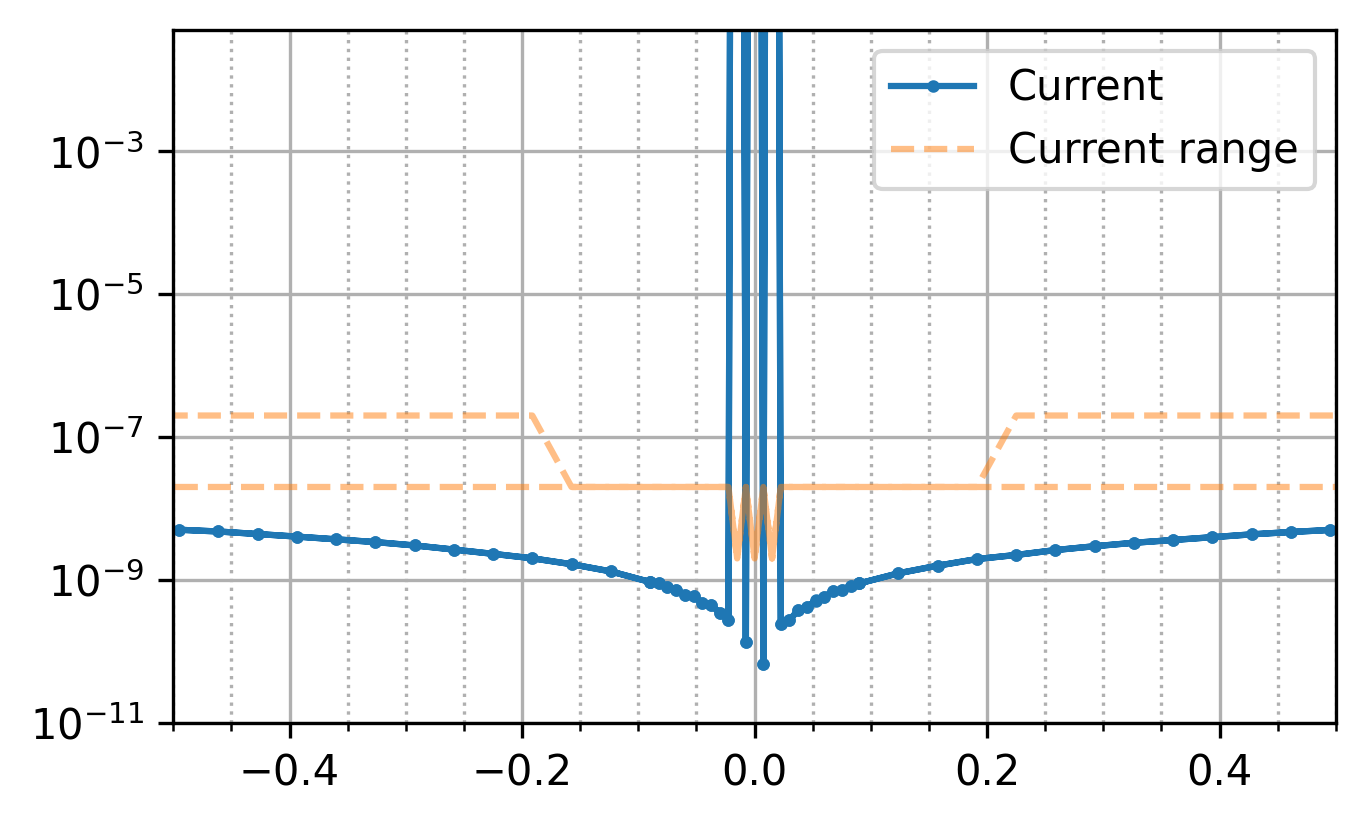

In [11]:
plt.figure(figsize=(5, 3), dpi=300)

plt.plot(V, abs(I2), 'o-', label='Current', markersize=2)
plt.plot(V, rng2, label='Current range', linestyle='--', alpha=0.5)
# plt.vlines([-0.10204081632653073, 0.1428571428571428 ], ymin = 0, ymax=1e38, color='black', linestyles=':')
plt.ylim(1e-11, 5e-2)
plt.xlim(-0.5, 0.5)
plt.minorticks_on()
plt.grid(visible=True, which='major') 
plt.grid(visible=True, which='minor', linestyle=':') 
plt.yscale('log')
plt.legend();

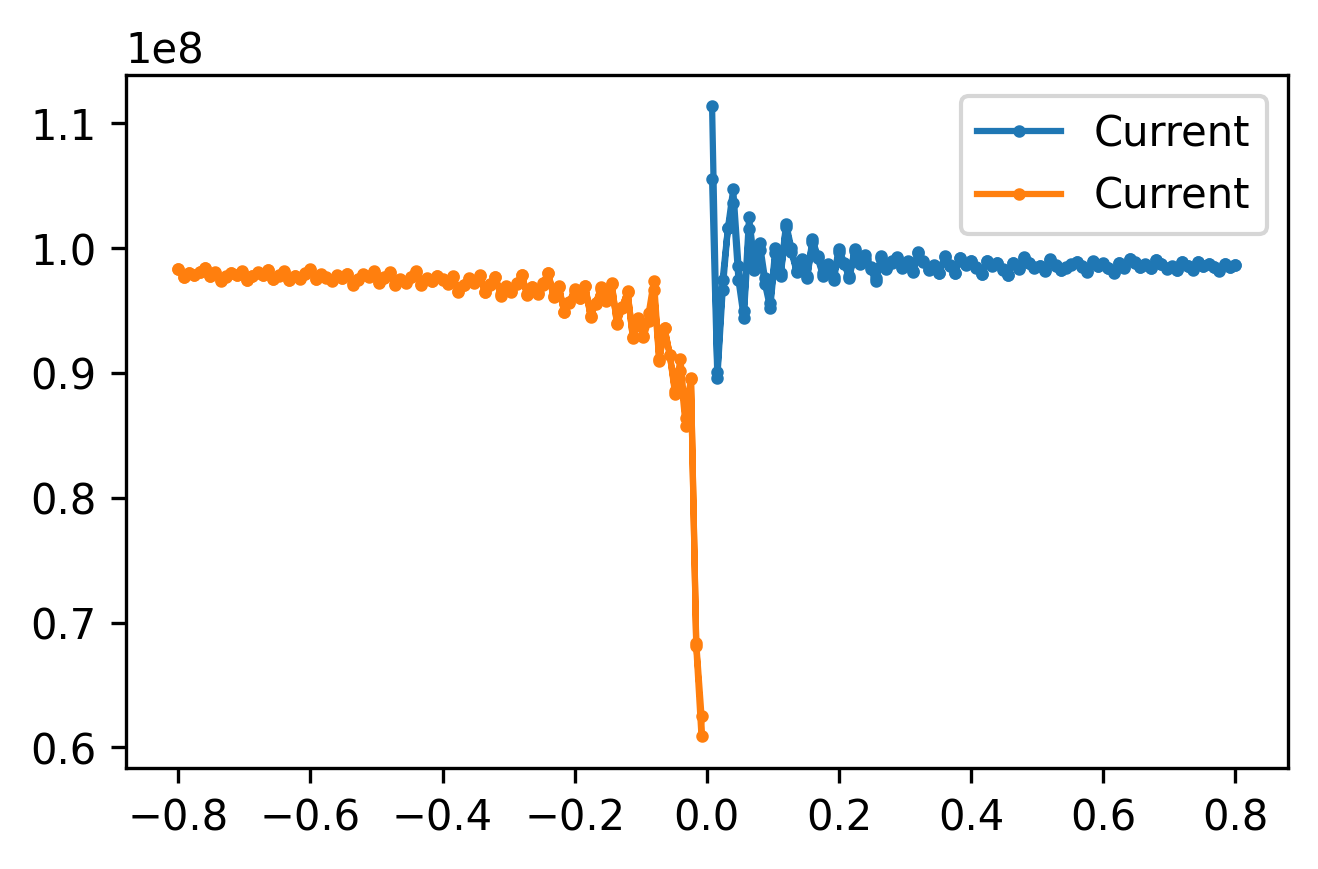

In [77]:
plt.figure(figsize=(5, 3), dpi=300)

plt.plot(V[V > 0], V[V > 0] / I[V > 0], 'o-', label='Current', markersize=2)
plt.plot(V[V < 0], V[V < 0] / I[V < 0], 'o-', label='Current', markersize=2)
# plt.plot(V, [i[1] for i in r], label='Current range')
# plt.vlines([-0.10204081632653073, 0.1428571428571428 ], ymin = 0, ymax=1e38, color='black', linestyles=':')
# plt.ylim(0, 2.1e-8)
# plt.yscale('log')
plt.legend();

In [25]:
len(r)

22

In [5]:
eval('2.0000000E-02\n')

0.02

: 

In [38]:
K.device.write(":SENS:CURR:NPLC 10")

20

In [17]:
K.device.write(':SOUR:VOLT:MCON 1;')
# K.device.read()

20

In [102]:
K.set_voltage_range(2)

Voltage range set to 2 V


In [11]:
K.set_voltage(0)
K.device.write('OUTP OFF;')

11

In [53]:
K.device.write(':SENS:RES:MAN:VSO:OPER ON;')

28

In [41]:
K.set_voltage(0)

In [40]:
while 1:
    K.set_voltage(0)
    # time.sleep(1e-3)
    K.set_voltage(1)
    # time.sleep(1e-3)

KeyboardInterrupt: 

In [90]:
K.device.write('MEAS:CURR?;')
K.device.read()

'+00.03107E-09NADC,08:34:48.00,09-Oct-2024,+02196RDNG#\n'

In [18]:

K.set_voltage(1)
K.device.write(':READ?;')
K.device.read()

'+0100.324E-09NADC,+0001631.117625secs,+02708RDNG#\n'

In [100]:
I = []
V = []
# keithley.source_voltage = 0
# keithley.enable_source()
# keithley.apply_voltage(voltage_range=5)
# keithley.measure_current(nplc=1, current=0.000105, auto_range=True)

for (v, i) in measure_IV(K, npoints=100):
    I.append(i)
    V.append(v)
    # print(i, v)

Voltage set to 0.5005 V and output enabled
Voltage set to 0.5005050505050505 V and output enabled
Voltage set to 0.500510101010101 V and output enabled
Voltage set to 0.5005151515151515 V and output enabled
Voltage set to 0.500520202020202 V and output enabled
Voltage set to 0.5005252525252525 V and output enabled
Voltage set to 0.500530303030303 V and output enabled
Voltage set to 0.5005353535353535 V and output enabled
Voltage set to 0.500540404040404 V and output enabled
Voltage set to 0.5005454545454545 V and output enabled
Voltage set to 0.500550505050505 V and output enabled
Voltage set to 0.5005555555555555 V and output enabled
Voltage set to 0.500560606060606 V and output enabled
Voltage set to 0.5005656565656565 V and output enabled
Voltage set to 0.500570707070707 V and output enabled


KeyboardInterrupt: 

In [19]:
I, V

([-3.78e-11,
  1.6824e-09,
  2.6877e-09,
  3.3639e-09,
  4.4153e-09,
  5.4408e-09,
  6.4656e-09,
  7.4951e-09,
  8.5321e-09,
  9.5453e-09,
  1.05625e-08,
  1.15878e-08,
  1.26278e-08,
  1.36337e-08,
  1.46672e-08,
  1.5696e-08,
  1.67143e-08,
  1.77196e-08,
  1.87564e-08,
  1.97677e-08,
  2.04601e-08,
  2.14786e-08,
  2.25018e-08,
  2.35385e-08,
  2.45332e-08,
  2.55718e-08,
  2.66205e-08,
  2.76335e-08,
  2.86568e-08,
  2.9685e-08,
  3.07021e-08,
  3.17564e-08,
  3.27513e-08,
  3.37831e-08,
  3.48186e-08,
  3.585e-08,
  3.6867e-08,
  3.79109e-08,
  3.85967e-08,
  3.96099e-08,
  4.0638e-08,
  4.16471e-08,
  4.26916e-08,
  4.36925e-08,
  4.47111e-08,
  4.57403e-08,
  4.67689e-08,
  4.78025e-08,
  4.88403e-08,
  4.985e-08,
  5.12174e-08,
  5.22579e-08,
  5.32803e-08,
  5.42957e-08,
  5.53136e-08,
  5.63606e-08,
  5.73673e-08,
  5.83954e-08,
  5.94173e-08,
  6.04365e-08,
  6.14492e-08,
  6.24757e-08,
  6.34941e-08,
  6.41786e-08,
  6.52068e-08,
  6.623e-08,
  6.726e-08,
  6.82843e-08,
  6

Text(0, 0.5, 'Current (A)')

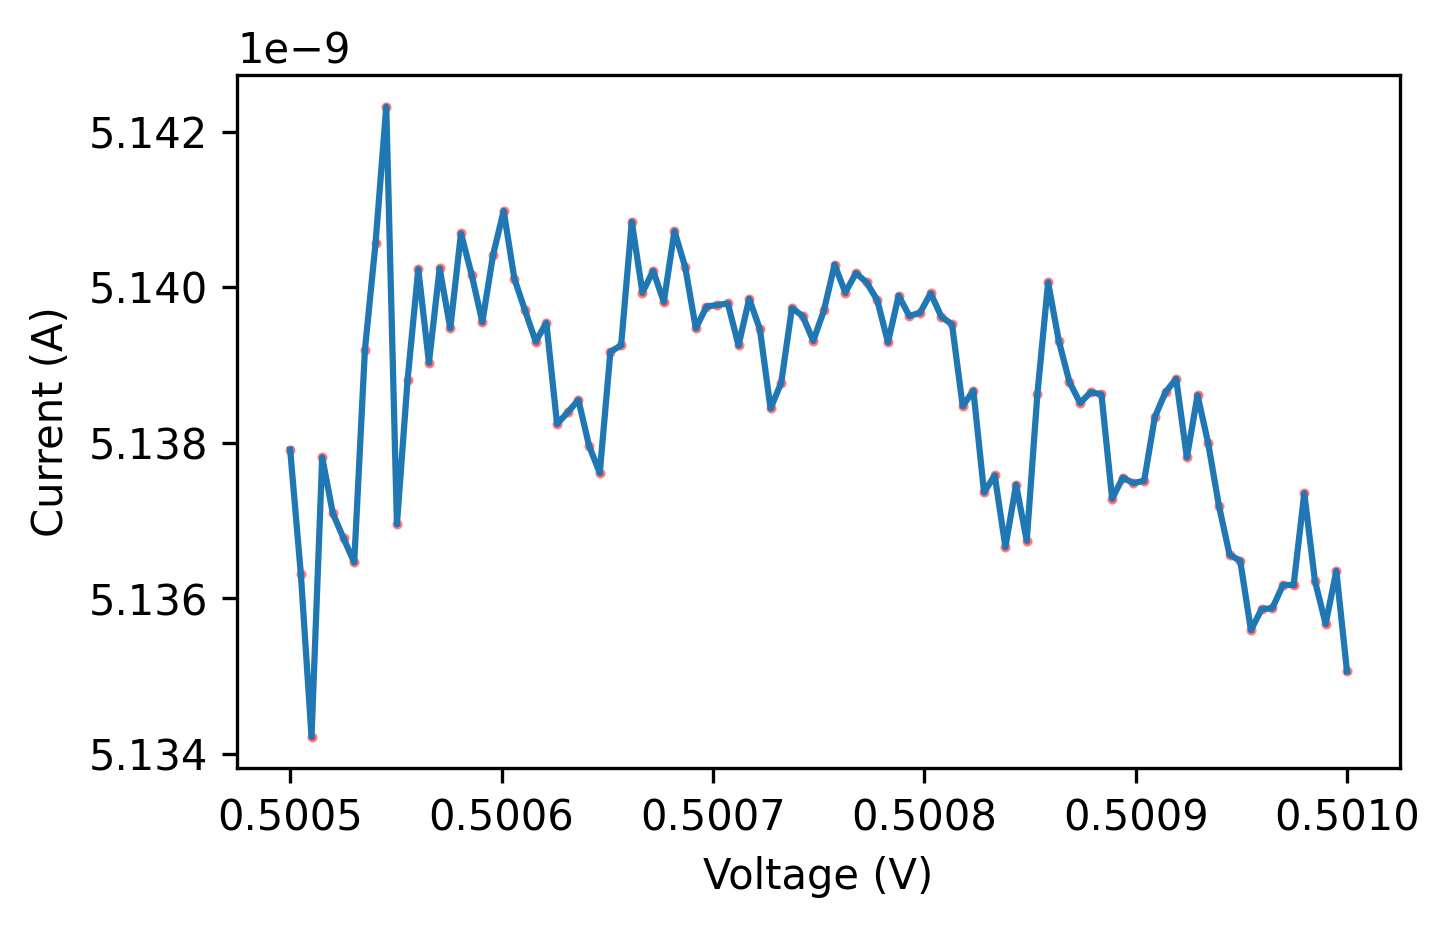

In [85]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(V, I)
plt.scatter(V, I, s=2, color='red', alpha=0.5)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
# plt.show()

Text(0, 0.5, 'Resistance (R)')

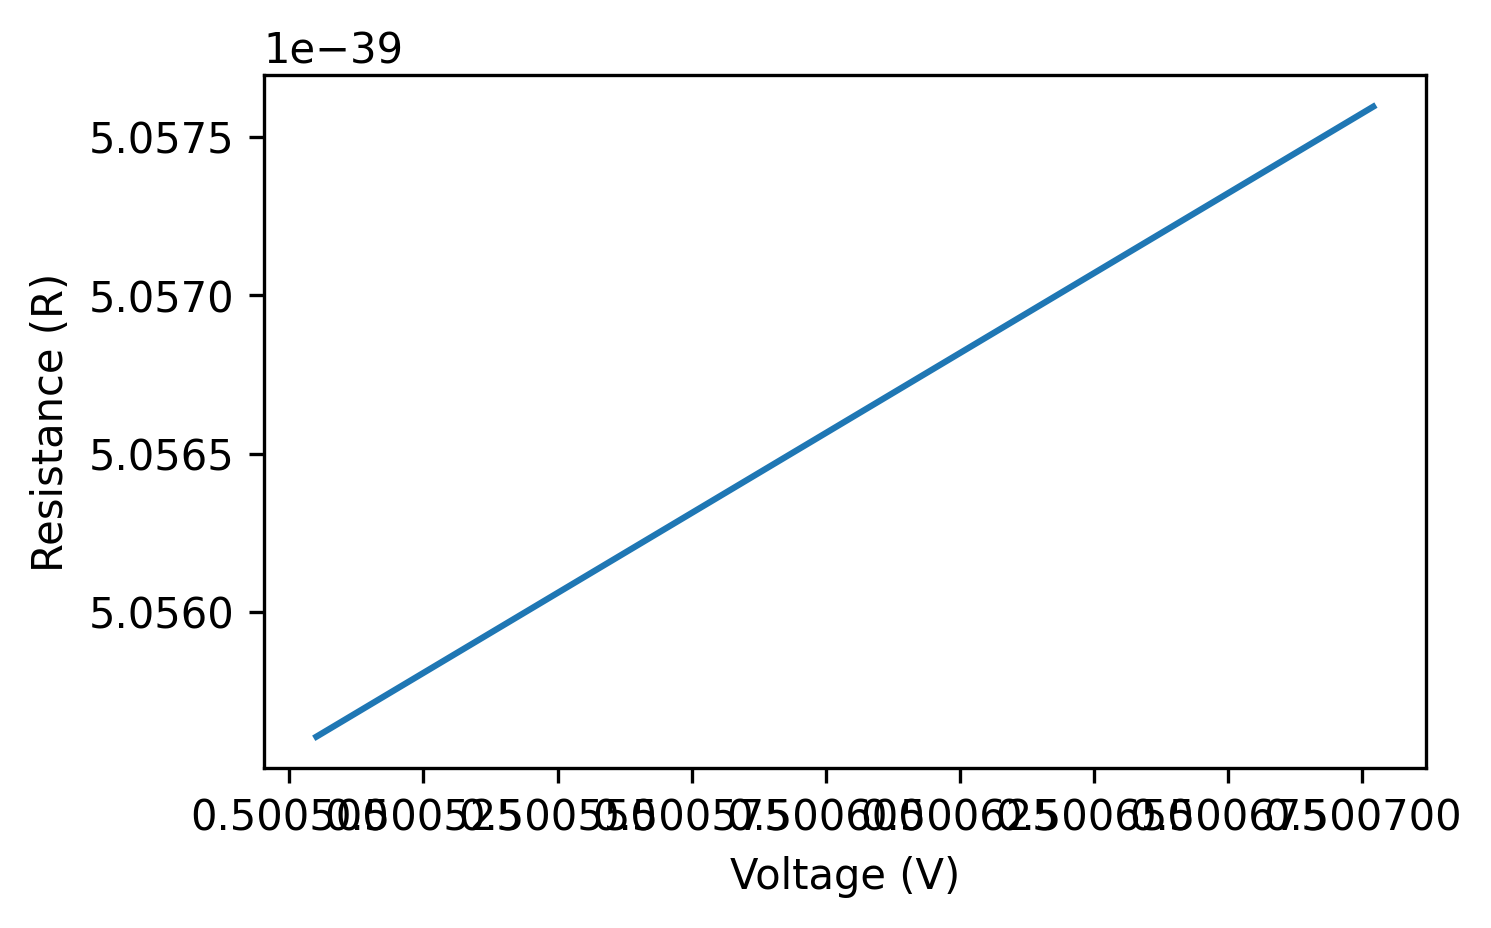

In [92]:
V = np.array(V)
plt.figure(figsize=(5, 3), dpi=300)
# plt.plot(V[10:], (V/I)[10:])
plt.plot(V[1:], (V/I)[1:])
plt.xlabel('Voltage (V)')
plt.ylabel('Resistance (R)')
# plt.show()

In [24]:
K.close()

Connection to Keithley 6517B closed.
